# Environment Setup

In [ ]:
!pip install alpha_vantage


In [ ]:
!pip install mplfinance pandas


In [ ]:
!pip install fastapi uvicorn pandas

In [ ]:
!pip install langdetect

In [1]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29423 sha256=4122e65eb6db0ffb57fd205c8128e91972fa2c7ea940223848e37132a512ece2
  Stored in directory: c:\users\sheng\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [16]:
!pip install tensorflow

In [9]:
import yfinance as yf
import pandas as pd
import requests
from datetime import datetime, timedelta
import re
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os
from alpha_vantage.timeseries import TimeSeries
import time
import mplfinance as mpf
import ta

# Data Collection

## Stock Data

### Alpha Vantage

In [ ]:
# Api Key
api = X29K76EJP70V2JGP
FOD3B9ESO9W0Y9UE
SRKSUHDAW2DL6Y3B

#### 10 year

Check Data

In [7]:
# List of stock symbols to process
stock_list = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]  # Add more if needed

# List of years (2014-2024) and months
years = list(range(2014, 2025))
months_10yr = [f"{y}-{str(m).zfill(2)}" for y in years for m in range(1, 13)]

# Stock market holidays (2014–2024)
stock_market_holidays = [
    "2024-01-01", "2024-01-15", "2024-02-19", "2024-03-29", "2024-05-27", "2024-06-19",
    "2024-07-04", "2024-09-02", "2024-11-28", "2024-12-25", "2023-01-02", "2023-01-16",
    "2023-02-20", "2023-04-07", "2023-05-29", "2023-06-19", "2023-07-04", "2023-09-04", 
    "2023-11-23", "2023-12-25", "2022-01-01", "2022-01-17", "2022-02-21", "2022-04-15", 
    "2022-05-30", "2022-06-20", "2022-07-04", "2022-09-05", "2022-11-24", "2022-12-26", 
    "2021-01-01", "2021-01-18", "2021-02-15", "2021-04-02", "2021-05-31", "2021-07-05", 
    "2021-09-06", "2021-11-25", "2021-12-24", "2020-01-01", "2020-01-20", "2020-02-17", 
    "2020-04-10", "2020-05-25", "2020-07-03", "2020-09-07", "2020-11-26", "2020-12-25", 
    "2019-01-01", "2019-01-21", "2019-02-18", "2019-04-19", "2019-05-27", "2019-07-04", 
    "2019-09-02", "2019-11-28", "2019-12-25", "2018-01-01", "2018-01-15", "2018-02-19",
    "2018-03-30", "2018-05-28", "2018-07-04", "2018-09-03", "2018-11-22", "2018-12-05",
    "2018-12-25", "2017-01-02", "2017-01-16", "2017-02-20", "2017-04-14", "2017-05-29",
    "2017-07-04", "2017-09-04", "2017-11-23", "2017-12-25", "2016-01-01", "2016-01-18",
    "2016-02-15", "2016-03-25", "2016-05-30", "2016-07-04", "2016-09-05", "2016-11-24",
    "2016-12-26", "2015-01-01", "2015-01-19", "2015-02-16", "2015-04-03", "2015-05-25",
    "2015-07-03", "2015-09-07", "2015-11-26", "2015-12-25", "2014-01-01", "2014-01-20", 
    "2014-02-17", "2014-04-18", "2014-05-26", "2014-07-04", "2014-09-01", "2014-11-27", 
    "2014-12-25"
]
stock_market_holidays = [pd.to_datetime(date).date() for date in stock_market_holidays]

# Function to check if a month's data is complete
def check_existing_data(symbol, month, output_dir):
    file_path = os.path.join(output_dir, f"{symbol}_30min_{month}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

        # Generate expected business days (Mon–Fri)
        expected_days = pd.date_range(start=f"{month}-01", end=f"{month}-28", freq="B")

        # Find missing weekdays (excluding holidays)
        missing_days = [d.date() for d in expected_days if d.date() not in df.index.date and d.date() not in stock_market_holidays]

        if missing_days:
            print(f"⚠️ WARNING: {symbol} {month} is missing these weekdays: {missing_days}")
            return False
        else:
            print(f"✅ {symbol} {month} data is already complete.")
            return True
    else:
        print(f"❌ {symbol} {month} data is missing.")
        return False

# Loop through each stock
for symbol in stock_list:
    print(f"\n📦 Checking data for {symbol}...")

    output_dir = f"{symbol}_30min_data"
    os.makedirs(output_dir, exist_ok=True)

    # Skip if already completed
    completion_flag = os.path.join(output_dir, "completed.flag")
    if os.path.exists(completion_flag):
        print(f"✅ {symbol} already marked as complete. Skipping.")
        continue

    # Check for missing months
    months_to_fetch = [month for month in months_10yr if not check_existing_data(symbol, month, output_dir)]

    # Save missing months list
    missing_months_file = os.path.join(output_dir, "missing_months_10yr.txt")
    with open(missing_months_file, "w") as f:
        for month in months_to_fetch:
            f.write(month + "\n")

    print(f"📊 {symbol} months that need to be fetched: {months_to_fetch}")
    print(f"📝 Missing months list saved in {missing_months_file}")

    # Create completion flag if nothing is missing
    if not months_to_fetch:
        with open(completion_flag, "w") as f:
            f.write("complete")
        print(f"🏁 All data fetched for {symbol}. Completion flag set.")


📦 Checking data for AAPL...
✅ AAPL already marked as complete. Skipping.

📦 Checking data for MSFT...
✅ MSFT 2014-01 data is already complete.
✅ MSFT 2014-02 data is already complete.
✅ MSFT 2014-03 data is already complete.
✅ MSFT 2014-04 data is already complete.
✅ MSFT 2014-05 data is already complete.
✅ MSFT 2014-06 data is already complete.
✅ MSFT 2014-07 data is already complete.
✅ MSFT 2014-08 data is already complete.
✅ MSFT 2014-09 data is already complete.
✅ MSFT 2014-10 data is already complete.
✅ MSFT 2014-11 data is already complete.
✅ MSFT 2014-12 data is already complete.
✅ MSFT 2015-01 data is already complete.
✅ MSFT 2015-02 data is already complete.
✅ MSFT 2015-03 data is already complete.
✅ MSFT 2015-04 data is already complete.
✅ MSFT 2015-05 data is already complete.
✅ MSFT 2015-06 data is already complete.
✅ MSFT 2015-07 data is already complete.
✅ MSFT 2015-08 data is already complete.
✅ MSFT 2015-09 data is already complete.
✅ MSFT 2015-10 data is already compl

Get Data

In [6]:
import os
import time
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

# Alpha Vantage API Key
api_key = "SRKSUHDAW2DL6Y3B"
ts = TimeSeries(key=api_key, output_format="pandas")

# List of stocks
stock_list = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]

# Loop through each stock
for symbol in stock_list:
    print(f"\n🚀 Starting data collection for {symbol}")

    output_dir = f"{symbol}_30min_data"
    missing_months_file = os.path.join(output_dir, "missing_months_10yr.txt")
    completion_flag = os.path.join(output_dir, "completed.flag")

    # Skip if already marked complete
    if os.path.exists(completion_flag):
        print(f"✅ {symbol} already marked as complete. Skipping.")
        continue

    # Check if missing months file exists
    try:
        with open(missing_months_file, "r") as f:
            months_to_fetch = f.read().splitlines()
    except FileNotFoundError:
        print(f"✅ No missing months file for {symbol}. Skipping.")
        continue

    # Flag to detect if any errors occurred
    error_occurred = False

    # Fetch data month-by-month
    for month in months_to_fetch:
        output_file = os.path.join(output_dir, f"{symbol}_30min_{month}.csv")

        try:
            print(f"📊 Fetching {symbol} data for {month}...")

            # Fetch data from Alpha Vantage
            data, _ = ts.get_intraday(
                symbol=symbol,
                interval="30min",
                month=month,
                adjusted=True,
                extended_hours=False,
                outputsize="full"
            )

            # Convert index to datetime
            data.index = pd.to_datetime(data.index)
            data.columns = ["Open", "High", "Low", "Close", "Volume"]

            # Save to CSV
            data.to_csv(output_file)
            print(f"✅ Saved {symbol} data for {month}")
            time.sleep(12)  # Respect API rate limit

        except Exception as e:
            print(f"❌ Error fetching {symbol} data for {month}: {e}")
            print("⚠️ Stopping fetch for this stock. You can rerun to continue.")
            error_occurred = True
            break  # Stop current stock's loop

    # Mark as complete if no errors
    if not error_occurred:
        with open(completion_flag, "w") as f:
            f.write("complete")
        print(f"🏁 All data for {symbol} fetched. Completion flag created.")

print("\n✅ All stock data fetching processes completed.")



🚀 Starting data collection for AAPL
✅ AAPL already marked as complete. Skipping.

🚀 Starting data collection for MSFT
📊 Fetching MSFT data for 2018-01...
✅ Saved MSFT data for 2018-01
📊 Fetching MSFT data for 2018-02...
✅ Saved MSFT data for 2018-02
📊 Fetching MSFT data for 2018-03...
✅ Saved MSFT data for 2018-03
📊 Fetching MSFT data for 2018-04...
✅ Saved MSFT data for 2018-04
📊 Fetching MSFT data for 2018-05...
✅ Saved MSFT data for 2018-05
📊 Fetching MSFT data for 2018-06...
✅ Saved MSFT data for 2018-06
📊 Fetching MSFT data for 2018-07...
✅ Saved MSFT data for 2018-07
📊 Fetching MSFT data for 2018-08...
✅ Saved MSFT data for 2018-08
📊 Fetching MSFT data for 2018-09...
✅ Saved MSFT data for 2018-09
📊 Fetching MSFT data for 2018-10...
✅ Saved MSFT data for 2018-10
📊 Fetching MSFT data for 2018-11...
✅ Saved MSFT data for 2018-11
📊 Fetching MSFT data for 2018-12...
✅ Saved MSFT data for 2018-12
📊 Fetching MSFT data for 2019-01...
✅ Saved MSFT data for 2019-01
📊 Fetching MSFT data fo

### Merge All Data

In [8]:
# === List of all stock symbols you want to merge ===
stock_list = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]  # Add/remove symbols as needed

# Create output directory for merged data
output_dir = "30min_data"
os.makedirs(output_dir, exist_ok=True)

# Loop through each stock symbol
for symbol in stock_list:
    print(f"\n🔄 Merging 30-minute data for {symbol}...")

    # Input directory for this stock
    data_dir = f"{symbol}_30min_data"

    # Find monthly CSV files
    csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv") and f.startswith(f"{symbol}_30min_")]
    csv_files.sort()  # Ensure chronological order

    merged_df = pd.DataFrame()

    # Load and concatenate each file
    for file in csv_files:
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")
        merged_df = pd.concat([merged_df, df])

    # Sort the merged data
    merged_df.sort_index(inplace=True)

    # Save to final CSV
    output_file = os.path.join(output_dir, f"{symbol}.csv")
    merged_df.to_csv(output_file)

    print(f"✅ Merged {symbol} data saved to {output_file}")



🔄 Merging 30-minute data for AAPL...
✅ Merged AAPL data saved to 30min_data\AAPL.csv

🔄 Merging 30-minute data for MSFT...
✅ Merged MSFT data saved to 30min_data\MSFT.csv

🔄 Merging 30-minute data for NVDA...
✅ Merged NVDA data saved to 30min_data\NVDA.csv

🔄 Merging 30-minute data for AMZN...
✅ Merged AMZN data saved to 30min_data\AMZN.csv

🔄 Merging 30-minute data for GOOGL...
✅ Merged GOOGL data saved to 30min_data\GOOGL.csv

🔄 Merging 30-minute data for META...
✅ Merged META data saved to 30min_data\META.csv

🔄 Merging 30-minute data for TSLA...
✅ Merged TSLA data saved to 30min_data\TSLA.csv

🔄 Merging 30-minute data for AMD...
✅ Merged AMD data saved to 30min_data\AMD.csv

🔄 Merging 30-minute data for NFLX...
✅ Merged NFLX data saved to 30min_data\NFLX.csv

🔄 Merging 30-minute data for AVGO...
✅ Merged AVGO data saved to 30min_data\AVGO.csv


### yfinance

#### Collect Data

In [ ]:
# Define stock symbols (Choose tech stocks or other relevant ones)
stock_symbols = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]

# Define output directory
output_dir = "yfinance"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Function to fetch full historical stock data
def fetch_full_stock_data(stock_symbol):
    print(f"📊 Fetching full historical data for {stock_symbol}...")

    df = yf.download(stock_symbol, start="1900-01-01", interval="1d")  # Fetch from the first available date

    if df.empty:
        print(f"⚠️ No data found for {stock_symbol}!")
        return

    # Save to CSV inside the yfinance directory
    file_name = os.path.join(output_dir, f"{stock_symbol}_full_history.csv")
    df.to_csv(file_name)

    print(f"✅ {stock_symbol} full history saved as {file_name}")

# Fetch data for all selected stocks
for stock in stock_symbols:
    fetch_full_stock_data(stock)

print("📊 All stock historical data has been collected and saved in /yfinance/.")


In [ ]:
# Define input and output directories
input_dir = "yfinance"
output_dir = "cleaned_data"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

# List all CSV files in the yfinance folder
csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

# Function to check stock data for issues
def check_stock_data(file_path):
    df = pd.read_csv(file_path, skiprows=2)  # Skip first two header rows

    # Rename columns properly
    df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

    # Convert Date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

    # Convert numeric columns to float
    numeric_cols = ["Close", "High", "Low", "Open", "Volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Check for duplicates
    duplicate_count = df.duplicated(subset=["Date"]).sum()

    # Check for missing values
    missing_values = df.isnull().sum()

    print(f"\n📊 Checking {file_path}...")
    print(f"📅 Date Range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"🔄 Duplicate Dates: {duplicate_count}")
    print("❗ Missing Values Per Column:\n", missing_values)

    return df, duplicate_count, missing_values

# Function to clean and save stock data
def clean_stock_data(df, output_path):
    # Sort by date
    df.sort_values(by="Date", ascending=True, inplace=True)

    # Save the cleaned file without dropping duplicates/missing values
    df.to_csv(output_path, index=False)
    print(f"✅ Cleaned data saved as: {output_path}")

# Process all CSV files in yfinance directory
for file in csv_files:
    input_file_path = os.path.join(input_dir, file)
    output_file_path = os.path.join(output_dir, file.replace(".csv", "_cleaned.csv"))
    
    df, duplicate_count, missing_values = check_stock_data(input_file_path)
    
    # Only save the cleaned file (without dropping data)
    clean_stock_data(df, output_file_path)

print("\n✅ All stock data has been checked and saved in the 'cleaned_data/' folder.")


#### Avoid this first Check Missing Value

In [9]:
df = pd.read_csv("AAPL_historical_data.csv")  # Replace with any stock CSV file
print(df.info())  # Check data types and missing values
print(df.head())  # Preview first few rows


FileNotFoundError: [Errno 2] No such file or directory: 'AAPL_historical_data.csv'

## News Data

In [3]:
# Your NewsAPI Key
api_key = "31dbe344e851496e950dc899ab1d0e93"

# List of tech stocks to search for
tech_stocks = ["Apple", "Microsoft", "Nvidia", "Amazon", "Google", "Meta", "Tesla", "AMD", "Netflix", "Broadcom"]

# Date range for news (last 7 days)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')

# Function to fetch news for each stock
def fetch_news(stock):
    url = f"https://newsapi.org/v2/everything?q={stock}&language=en&from={start_date}&to={end_date}&sortBy=publishedAt&apiKey={api_key}"
    response = requests.get(url)
    return response.json()

# Collect news for all stocks
news_data = []
for stock in tech_stocks:
    data = fetch_news(stock)
    if "articles" in data:
        for article in data["articles"]:
            news_data.append({
                "Stock": stock,
                "Title": article["title"],
                "content": article["content"],
                "Source": article["source"]["name"],
                "Published At": article["publishedAt"],
                "URL": article["url"]
            })

# Convert to DataFrame
df_news = pd.DataFrame(news_data)

# Save to CSV
df_news.to_csv("tech_stock_news.csv", index=False)

print("News data collected and saved to 'tech_stock_news.csv'.")


News data collected and saved to 'tech_stock_news.csv'.


In [8]:
# Load the collected news data
df_news = pd.read_csv("tech_stock_news.csv")

# Display first few rows
print(df_news.head())


   Stock                                              Title  \
0  Apple        Veronica Mars Season 1-4 $4.99 via Apple TV   
1  Apple  Protecting your iCloud data after Apple’s Adva...   
2  Apple  Praying through Weaknesses as a Couple - Cross...   
3  Apple  This hybrid smartwatch finally convinced me to...   
4  Apple  Apple's New Passwords App Left Users Exposed T...   

                                             content             Source  \
0  This collaborative space allows users to contr...     Slickdeals.net   
1  Advanced Data Protection (ADP) secures iCloud ...  Help Net Security   
2  Praying through Weaknesses as a CoupleBy Lynet...      Crosswalk.com   
3  I used dozens of Wear OS smartwatches over the...    Android Central   
4  Security researchers found that the Passwords ...         Biztoc.com   

           Published At                                                URL  
0  2025-03-19T05:01:02Z  https://slickdeals.net/f/18188056-veronica-mar...  
1  2025-03-19T05

# Preprocessing

In [13]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply cleaning
df_news["Cleaned_Title"] = df_news["Title"].apply(clean_text)

# Save cleaned data
df_news.to_csv("cleaned_tech_stock_news1.csv", index=False)

print("Data cleaned and saved.")


Data cleaned and saved.


# Sentiment Analysis

## FinBERT model

In [14]:
# Load FinBERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")


In [15]:
import torch.nn.functional as F

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)

    # Labels: 0 = Negative, 1 = Neutral, 2 = Positive
    labels = ["Negative", "Neutral", "Positive"]
    sentiment = labels[torch.argmax(probs).item()]
    
    return sentiment

# Test on an example headline
example_headline = "Apple stock soars as earnings beat expectations"
print(f"Sentiment: {predict_sentiment(example_headline)}")


Sentiment: Neutral


In [20]:
import pandas as pd

# Load dataset
df_news = pd.read_csv("cleaned_tech_stock_news1.csv")

# Remove rows where "Cleaned_Title" is NaN or not a string
df_news = df_news.dropna(subset=["Cleaned_Title"])  # Drop missing values
df_news = df_news[df_news["Cleaned_Title"].apply(lambda x: isinstance(x, str))]  # Keep only string values

# Save cleaned dataset
df_news.to_csv("cleaned_tech_stock_news_filtered.csv", index=False)

print(f"✅ Removed invalid rows. Remaining data: {len(df_news)} rows.")


✅ Removed invalid rows. Remaining data: 986 rows.


In [23]:
import pandas as pd
from langdetect import detect

# Load dataset
df_news = pd.read_csv("cleaned_tech_stock_news1.csv")

# Function to detect language
def is_english(text):
    try:
        return detect(text) == "en"  # Keep only English text
    except:
        return False  # If detection fails, remove the row

# Apply language filter
df_news = df_news[df_news["Cleaned_Title"].apply(is_english)]

# Save cleaned dataset
df_news.to_csv("cleaned_tech_stock_news_english.csv", index=False)

print(f"✅ Removed non-English titles. Remaining rows: {len(df_news)}")


✅ Removed non-English titles. Remaining rows: 894


In [25]:
df_news = pd.read_csv("cleaned_tech_stock_news_filtered.csv")

# Apply sentiment analysis to each headline
df_news["Sentiment"] = df_news["Cleaned_Title"].apply(predict_sentiment)

# Save results
df_news.to_csv("news_sentiment_analysis1.csv", index=False)

print("Sentiment analysis complete. Results saved.")


Sentiment analysis complete. Results saved.


In [26]:
# Load the dataset with sentiment analysis results
df_news = pd.read_csv("news_sentiment_analysis1.csv")

# Count the occurrences of each sentiment category
sentiment_counts = df_news["Sentiment"].value_counts()

# Display results
print(sentiment_counts)


Sentiment
Negative    723
Neutral     150
Positive    113
Name: count, dtype: int64


# Chart Analysis

# LSTM

## Add Indicator

In [10]:
# List of stock symbols
stock_list = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]

# Input and output folders
input_dir = "30min_data"
output_dir = "lstm_input"
os.makedirs(output_dir, exist_ok=True)

# Loop through each stock
for symbol in stock_list:
    input_file = os.path.join(input_dir, f"{symbol}.csv")
    output_file = os.path.join(output_dir, f"{symbol}_with_indicators.csv")

    # Check if file exists
    if not os.path.exists(input_file):
        print(f"❌ Skipping {symbol}: Data file not found.")
        continue

    print(f"📊 Processing indicators for {symbol}...")

    try:
        # Load data
        df = pd.read_csv(input_file, parse_dates=["date"], index_col="date")

        # Drop missing values (optional, can be replaced with fillna)
        df.dropna(inplace=True)

        # Add all TA indicators
        df = ta.add_all_ta_features(
            df,
            open="Open",
            high="High",
            low="Low",
            close="Close",
            volume="Volume",
            fillna=True
        )

        # Save result
        df.to_csv(output_file)
        print(f"✅ Saved: {output_file}")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")

print("🎯 All stock indicators processed.")


📊 Processing indicators for AAPL...


C:\Users\sheng\anaconda3\envs\FYP\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


✅ Saved: lstm_input\AAPL_with_indicators.csv
📊 Processing indicators for MSFT...


C:\Users\sheng\anaconda3\envs\FYP\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


✅ Saved: lstm_input\MSFT_with_indicators.csv
📊 Processing indicators for NVDA...
❌ Error processing NVDA: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for AMZN...
❌ Error processing AMZN: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for GOOGL...
❌ Error processing GOOGL: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for META...
❌ Error processing META: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for TSLA...
❌ Error processing TSLA: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for AMD...


C:\Users\sheng\anaconda3\envs\FYP\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


✅ Saved: lstm_input\AMD_with_indicators.csv
📊 Processing indicators for NFLX...
❌ Error processing NFLX: Missing column provided to 'parse_dates': 'date'
📊 Processing indicators for AVGO...
❌ Error processing AVGO: Missing column provided to 'parse_dates': 'date'
🎯 All stock indicators processed.


In [11]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

## Add Target

In [12]:
import pandas as pd

# Load your indicator-enriched data
df = pd.read_csv("lstm_input/AAPL_with_indicators.csv", parse_dates=["date"], index_col="date")

# Create binary target based on next day's close price
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Drop the last row (no label because of .shift(-1))
df.dropna(inplace=True)

# Optional: Check label distribution
print(df["Target"].value_counts())


Target
0    43943
1    43274
Name: count, dtype: int64


## MinMaxScaler

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Separate features and target
features = df.drop(columns=["Target"])
target = df["Target"]

# Initialize scaler and scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

# Add the target column back
df_scaled["Target"] = target.values

# Check the result
print(df_scaled.head())


                         Open      High       Low     Close    Volume  \
date                                                                    
2014-01-02 04:00:00  0.007498  0.007322  0.007661  0.007818  0.000405   
2014-01-02 04:30:00  0.007817  0.007286  0.007962  0.007795  0.000050   
2014-01-02 05:00:00  0.007727  0.007199  0.007790  0.007623  0.000025   
2014-01-02 05:30:00  0.007619  0.007132  0.007782  0.007651  0.000042   
2014-01-02 06:00:00  0.007830  0.007310  0.007852  0.007685  0.000178   

                     volume_adi  volume_obv  volume_cmf  volume_fi  volume_em  \
date                                                                            
2014-01-02 04:00:00    0.018454    0.057775    0.919694   0.633601   0.825245   
2014-01-02 04:30:00    0.018453    0.057773    0.814953   0.633600   0.825245   
2014-01-02 05:00:00    0.018453    0.057772    0.770817   0.633599   0.825244   
2014-01-02 05:30:00    0.018454    0.057773    0.790566   0.633600   0.825245   
20

In [14]:
import numpy as np

# Convert to NumPy array
data = df_scaled.values

# Define time step window size
time_steps = 30

# Create sequences
X, y = [], []
for i in range(time_steps, len(data)):
    X.append(data[i-time_steps:i, :-1])  # all features except Target
    y.append(data[i, -1])                # only the Target column

# Convert to arrays
X = np.array(X)
y = np.array(y)

print(f"✅ X shape: {X.shape}")  # (samples, time_steps, features)
print(f"✅ y shape: {y.shape}")  # (samples,)


✅ X shape: (87187, 30, 91)
✅ y shape: (87187,)


## Train Test

In [15]:
# Choose a split ratio
train_size = int(len(X) * 0.8)

# Split the sequences
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"🧪 Train samples: {X_train.shape[0]}")
print(f"🧪 Test samples: {X_test.shape[0]}")


🧪 Train samples: 69749
🧪 Test samples: 17438


## Train Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


C:\Users\sheng\anaconda3\envs\FYP\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5055 - loss: 0.6944 - val_accuracy: 0.5053 - val_loss: 0.6931
Epoch 2/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5055 - loss: 0.6932 - val_accuracy: 0.4981 - val_loss: 0.6932
Epoch 3/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.4981 - val_loss: 0.6932
Epoch 4/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4981 - val_loss: 0.6933
Epoch 5/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5018 - loss: 0.6932 - val_accuracy: 0.4981 - val_loss: 0.6932
Epoch 6/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.4981 - val_loss: 0.6933
Epoch 7/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5072 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.6931
Epoch 8/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5063 -

## Evaluate

545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
✅ Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.94      0.65      8685
         1.0       0.51      0.06      0.11      8753

    accuracy                           0.50     17438
   macro avg       0.50      0.50      0.38     17438
weighted avg       0.50      0.50      0.38     17438



C:\Users\sheng\anaconda3\envs\FYP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


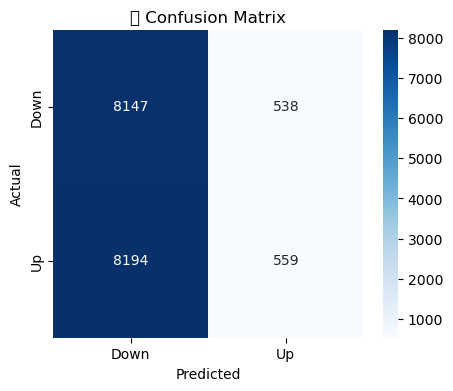

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary classes (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Evaluate
print("✅ Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix")
plt.show()
